# Exploratory analysis
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/workflow_data.csv").astype(
    {
        "name": "category",
        "status": "category",
        "conclusion": "category",
        "event": "category",
    }
)

In [3]:
print(f"{len(df)} Workflows in file after reading.")

488 Workflows in file after reading.


## Minimal preprocessing
---

In [4]:
df["name"] = df["name"].str.removeprefix(".github/workflows/").str.removesuffix(".yml").astype("category")

In [5]:
df[ ["created_day", "created_time"] ] = df["created_at"].str.split("T", expand=True)
df[ ["updated_day", "updated_time"] ] = df["updated_at"].str.split("T", expand=True)

In [6]:
df["created_time"] = df["created_time"].str.removesuffix("Z")
df["updated_time"] = df["updated_time"].str.removesuffix("Z")

In [7]:
df["created_dtime"] = pd.to_datetime(df["created_day"] + " " + df["created_time"])

In [8]:
df["updated_dtime"] = pd.to_datetime(df["updated_day"] + " " + df["updated_time"])

In [9]:
df = df.drop(["created_at", "updated_at", "created_day", "created_time", "updated_day", "updated_time"], axis=1)

In [10]:
df["runtime"] = df["updated_dtime"] - df["created_dtime"]

In [11]:
df["runtime"] = df["runtime"].dt.total_seconds() 

In [12]:
df.dtypes

id                        int64
name                   category
status                 category
conclusion             category
event                  category
run_attempt               int64
run_number                int64
created_dtime    datetime64[ns]
updated_dtime    datetime64[ns]
runtime                 float64
dtype: object

In [13]:
df.head()

,id,name,status,conclusion,event,run_attempt,run_number,created_dtime,updated_dtime,runtime
0,16102736480,test,completed,success,pull_request,1,361,2025-07-06 20:09:25,2025-07-06 20:13:36,251.0
1,16102736476,pr_benchmarks,completed,failure,pull_request,1,85,2025-07-06 20:09:25,2025-07-06 20:34:05,1480.0
2,16101639498,test,completed,success,pull_request,1,360,2025-07-06 17:47:55,2025-07-06 17:51:58,243.0
3,16101639490,pr_benchmarks,completed,failure,pull_request,1,84,2025-07-06 17:47:55,2025-07-06 18:12:39,1484.0
4,16100155623,test,completed,success,pull_request,1,359,2025-07-06 14:43:23,2025-07-06 14:47:36,253.0


## Some numbers
---

In [14]:
time_span = max(df["created_dtime"]) - min(df["created_dtime"])

In [15]:
print("Some numbers")
print(f"{len(df)} workflows registered over {time_span},")
print(f"~{len(df) / time_span.days:.2f} flows per day in estimate since,")
print()
print(f"{min(df["created_dtime"])} - earliest creation until,")
print(f"{max(df["created_dtime"])} - latest creation.")
print()
print("Workflow runtimes")
print(f"{sum(df["runtime"]):,.2f} runtime in seconds.")
print(f"{sum(df["runtime"]/60):,.2f} runtime in minutes.")
print(f"{sum(df["runtime"]/60)/60:,.2f} runtime in hours.")

Some numbers
488 workflows registered over 222 days 23:09:56,
~2.20 flows per day in estimate since,

2024-11-25 20:59:29 - earliest creation until,
2025-07-06 20:09:25 - latest creation.

Workflow runtimes
344,395.00 runtime in seconds.
5,739.92 runtime in minutes.
95.67 runtime in hours.


## Visualisations
---

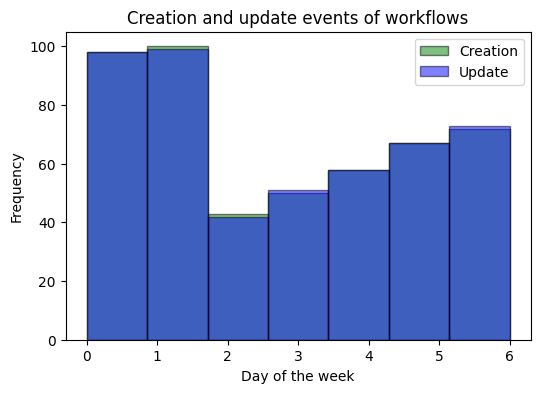

In [16]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(6, 4))

plt.hist(df["created_dtime"].dt.dayofweek, bins=7, alpha=0.5, label="Creation", color="green", edgecolor="black")
plt.hist(df["updated_dtime"].dt.dayofweek, bins=7, alpha=0.5, label="Update", color="blue", edgecolor="black")

plt.title("Creation and update events of workflows")
plt.xlabel("Day of the week")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

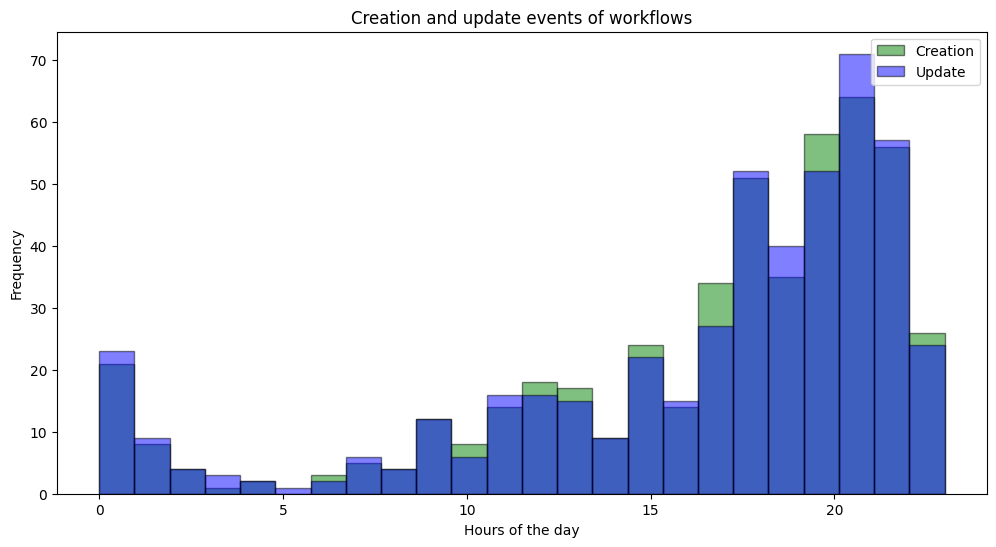

In [17]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(12, 6))

plt.hist(df["created_dtime"].dt.hour, bins=24, alpha=0.5, label="Creation", color="green", edgecolor="black")
plt.hist(df["updated_dtime"].dt.hour, bins=24, alpha=0.5, label="Update", color="blue", edgecolor="black")

plt.title("Creation and update events of workflows")
plt.xlabel("Hours of the day")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

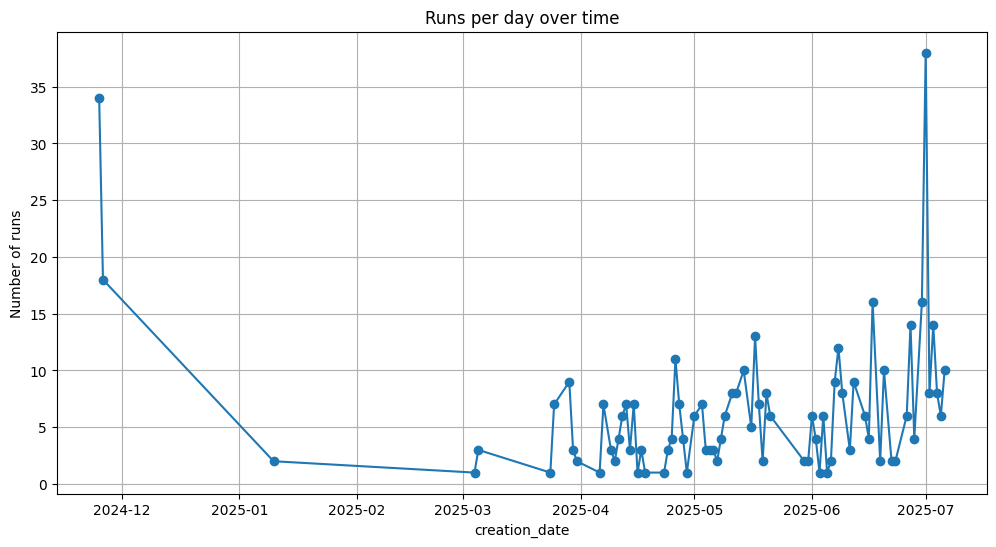

In [18]:
df["creation_date"] = df["created_dtime"].dt.date
counts = df.groupby("creation_date").size()

plt.figure(figsize=(12, 6))
counts.plot(kind="line", marker="o")
plt.grid(True)

# Adding titles and labels
plt.title("Runs per day over time")
plt.ylabel("Number of runs")

plt.show()

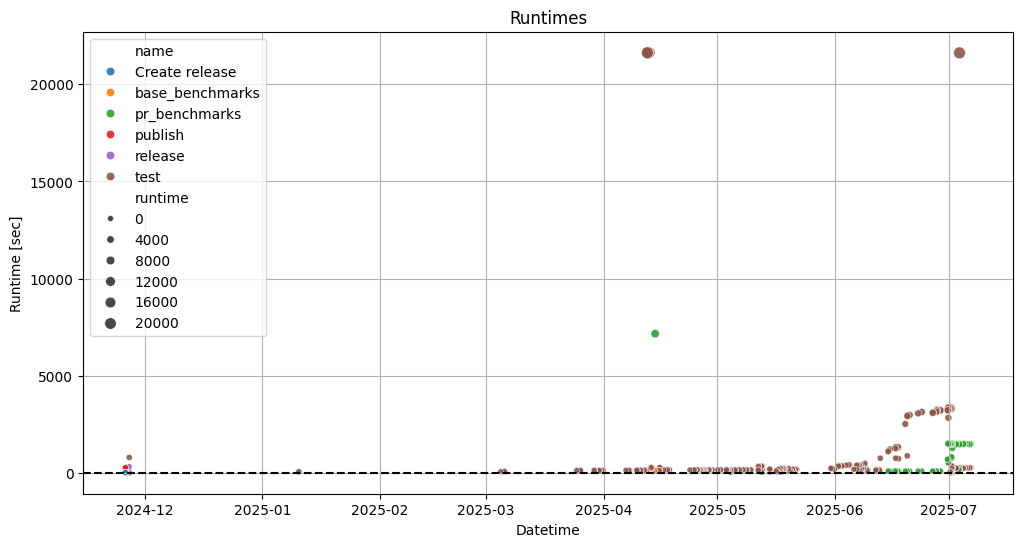

In [19]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="created_dtime", 
    y="runtime", 
    data=df, 
    alpha=0.9, 
    size="runtime",
    hue="name",
)


plt.title("Runtimes")
plt.xlabel("Datetime")
plt.ylabel("Runtime [sec]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis

plt.grid(True)
plt.show()

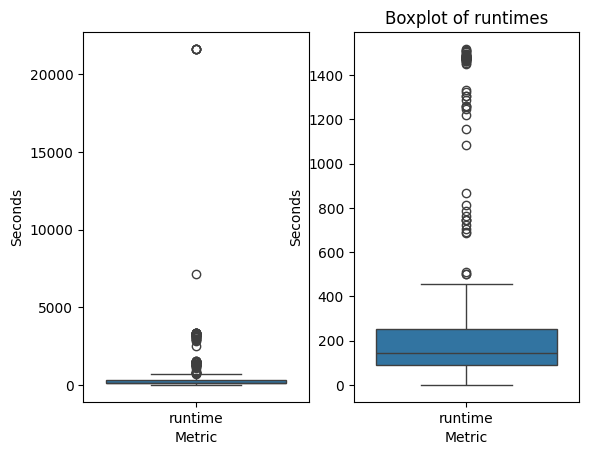

37 not plotted.


In [20]:
melted_data = df.melt(value_vars=["runtime"], var_name="Metric", value_name="Seconds")
temp_df = df.loc[df["runtime"] <= 2000]
temp_melted_data = temp_df.melt(value_vars=["runtime"], var_name="Metric", value_name="Seconds")

# Setting up the boxplots
fig, axes = plt.subplots(ncols=2)
sns.boxplot(x="Metric", y="Seconds", data=melted_data, legend=False, ax=axes[0])
sns.boxplot(x="Metric", y="Seconds", data=temp_melted_data, legend=False, ax=axes[1])

# Showing plot 
plt.title("Boxplot of runtimes")
plt.show()

print(f"{len(df) - len(temp_df)} not plotted.")

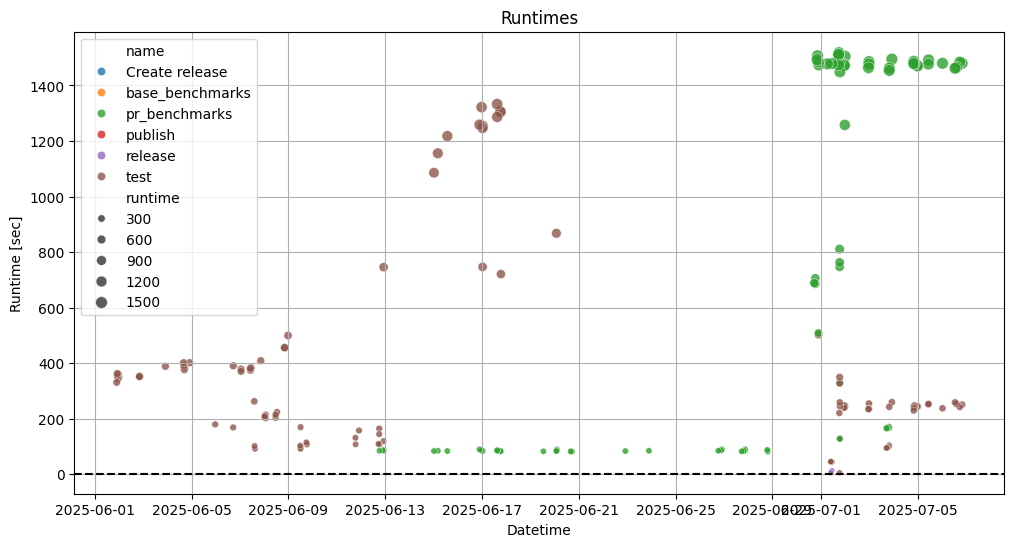

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="created_dtime", 
    y="runtime", 
    data=temp_df.loc[temp_df["created_dtime"] >= "2025-06-01"], 
    alpha=0.8, 
    size="runtime",
    hue="name"
)


plt.title("Runtimes")
plt.xlabel("Datetime")
plt.ylabel("Runtime [sec]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis

plt.grid(True)
plt.show()